# Compare and Calculate climatology and anomaly of ERA5/MERRA2 net shortwave and sst

In [84]:
import xarray as xr
import matplotlib.pyplot as plt
import json
import gcsfs
from scipy.signal import detrend
from scipy import stats
from scipy.stats import linregress

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

era23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr'))
merra23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean.zarr'))
#goes_t = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/sw_ds.zarr'))

era1022 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/surf_ds_2010_22.zarr'))
merra_1022 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean2010_2022.zarr'))

In [2]:
era_hrly = xr.concat([era1022, era23], dim='time')
merra_hrly = xr.concat([merra_1022, merra23], dim='time')

In [3]:
era_hrly

<xarray.Dataset> Size: 31GB
Dimensions:    (latitude: 41, longitude: 113, time: 120437)
Coordinates:
  * latitude   (latitude) float32 164B 21.0 21.25 21.5 21.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 963kB 2010-01-01 ... 2023-09-28T04:00:00
Data variables:
    slhf       (time, latitude, longitude) float64 4GB dask.array<chunksize=(2374, 11, 29), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 4GB dask.array<chunksize=(2374, 11, 29), meta=np.ndarray>
    ssr        (time, latitude, longitude) float64 4GB dask.array<chunksize=(2374, 11, 29), meta=np.ndarray>
    sst        (time, latitude, longitude) float64 4GB dask.array<chunksize=(2374, 11, 29), meta=np.ndarray>
    str        (time, latitude, longitude) float64 4GB dask.array<chunksize=(2374, 11, 29), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float64 4GB dask.array<chunksize=(115574, 11, 29), meta=np.ndarray>
    strd       (time, latitude, longitude) float64 4GB dask.array<chunksize=(115574, 11, 29), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [4]:
merra_hrly

<xarray.Dataset> Size: 2GB
Dimensions:   (lat: 21, lon: 45, time: 121248)
Coordinates:
  * lat       (lat) float64 168B 21.0 21.5 22.0 22.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 970kB 2010-01-01T00:30:00 ... 2023-10-31T...
Data variables:
    EFLUXWTR  (time, lat, lon) float32 458MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 458MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 458MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 458MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 458MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan00.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

## Shortwave

In [5]:
## convert from J/m^2 -> W/m^2
era_wm2 = era_hrly / (60*60)
#resample to daily freq (hourly too noisy
era = era_wm2.resample(time='D').mean('time')
merra = merra_hrly.sel(time=slice('2010', '2023-09-28')).resample(time='D').mean('time')
merra['EFLUXWTR'] = (-merra.EFLUXWTR)
merra['HFLUXWTR'] = (-merra.HFLUXWTR)

In [6]:
era.load()

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 5019, latitude: 41, longitude: 113)
Coordinates:
  * latitude   (latitude) float32 164B 21.0 21.25 21.5 21.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 40kB 2010-01-01 2010-01-02 ... 2023-09-28
Data variables:
    slhf       (time, latitude, longitude) float64 186MB -14.05 -18.46 ... nan
    sshf       (time, latitude, longitude) float64 186MB -41.33 ... -7.208
    ssr        (time, latitude, longitude) float64 186MB 69.84 68.71 ... nan nan
    sst        (time, latitude, longitude) float64 186MB nan nan nan ... nan nan
    str        (time, latitude, longitude) float64 186MB -40.41 ... -31.47
    ssrd       (time, latitude, longitude) float64 186MB nan nan nan ... 0.0 0.0
    strd       (time, latitude, longitude) float64 186MB nan nan ... 426.9 425.2
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-21 17:02:34 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [7]:
merra = merra.chunk({'lat':-1, 'lon':-1}).load()

In [18]:
era.time.sel(time='2010-01-01', method='nearest').values

numpy.datetime64('2010-01-01T00:00:00.000000000')

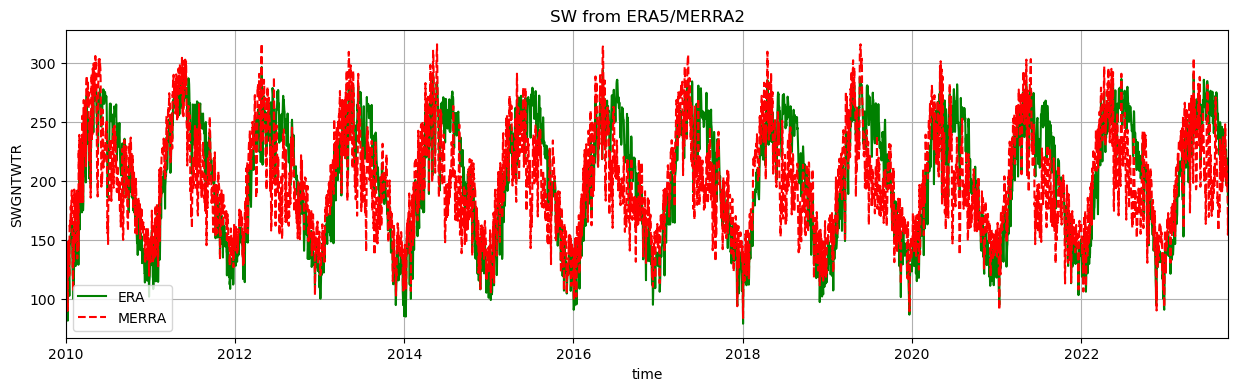

In [22]:
era.ssr.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='green', label='ERA')
#sw_goes.sel(time=slice('2023-01-01', '2023-09-30')).mean(['lat', 'lon']).plot(color='silver', label='GOES')
merra.SWGNTWTR.mean(['lat', 'lon']).plot(color='red', linestyle='--',label='MERRA')
plt.grid()
plt.legend()
plt.xlim(era.time.sel(time='2010-01-01', method='nearest'), 
         era.time.sel(time='2023-10-01', method='nearest'))
plt.title('SW from ERA5/MERRA2');

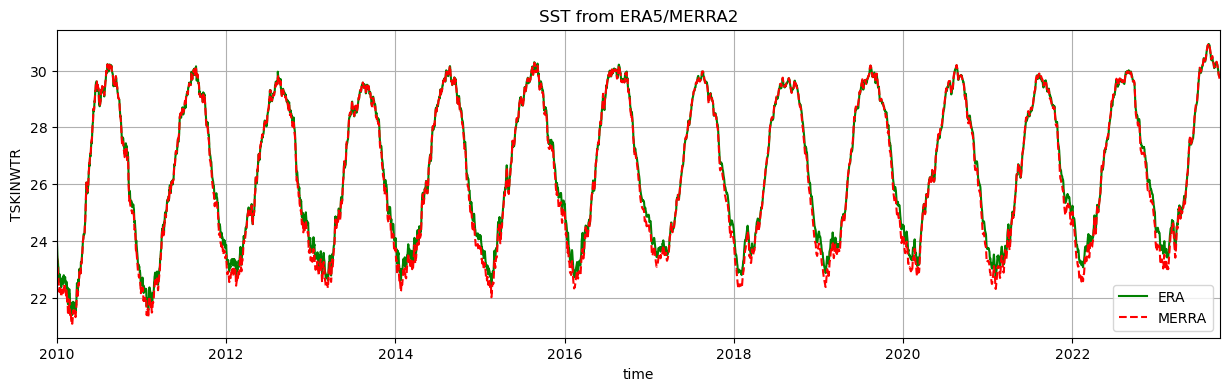

In [23]:
(era_hrly.sst-273.15).resample(time='D').mean().mean(['latitude', 'longitude']).plot(figsize=(15,4), color='green', label='ERA')
#sw_goes.sel(time=slice('2023-01-01', '2023-09-30')).mean(['lat', 'lon']).plot(color='silver', label='GOES')
(merra.TSKINWTR-273.15).mean(['lat', 'lon']).plot(color='red', linestyle='--',label='MERRA')
plt.grid()
plt.legend()
plt.xlim(era.time.sel(time='2010-01-01', method='nearest'), 
         era.time.sel(time='2023-10-01', method='nearest'))
plt.title('SST from ERA5/MERRA2');

In [80]:
sst_e = (era_hrly.sst-273.15).resample(time='D').mean().mean(['latitude', 'longitude'])
sst_m = (merra.TSKINWTR-273.15).mean(['lat', 'lon'])

In [126]:
lr_e = linregress(np.arange(0,5019), sst_e.fillna(0.))
lr_m = linregress(np.arange(0,5019), sst_m.fillna(0.))

In [127]:
lr_e

LinregressResult(slope=0.0002263355792741423, intercept=25.90959666509753, rvalue=0.1314295679141303, pvalue=8.816621354553052e-21, stderr=2.4102049886244557e-05, intercept_stderr=0.0698305795436356)

In [128]:
lr_m

LinregressResult(slope=0.0002334947336297513, intercept=25.755159409245806, rvalue=0.13013934476941957, pvalue=2.1064587109534427e-20, stderr=2.511523606604332e-05, intercept_stderr=0.07276607168869703)

In [132]:
trend_e = (lr_e[0]*np.arange(0, 5019) + lr_e[1])
trend_m = (lr_m[0]*np.arange(0, 5019) + lr_m[1])

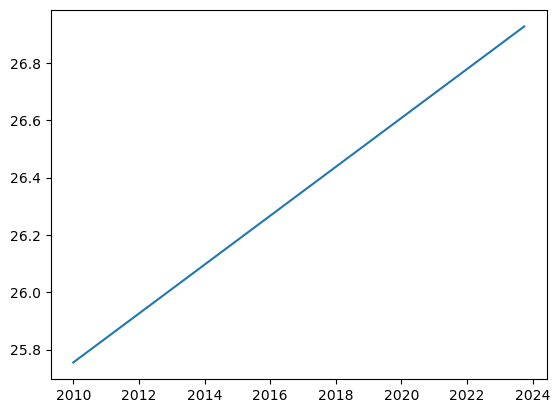

In [135]:
plt.plot(merra.time, trend_m)

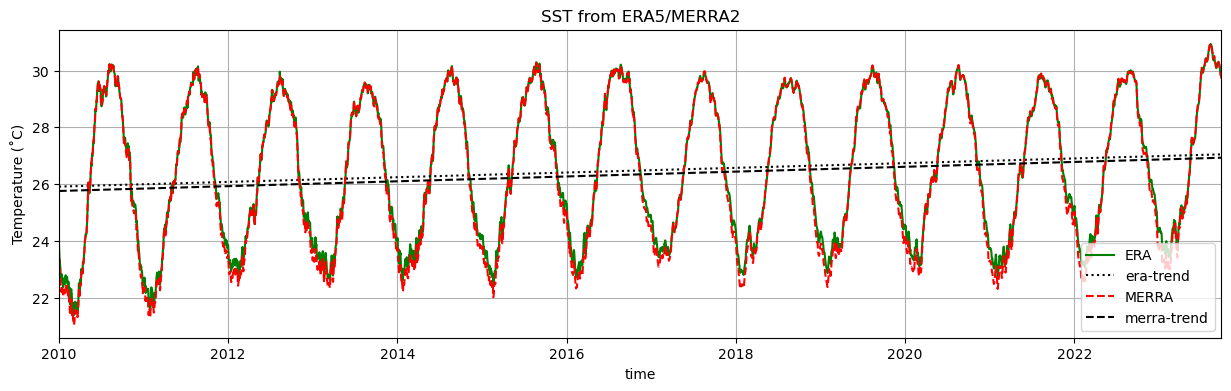

In [138]:
(era_hrly.sst-273.15).resample(time='D').mean().mean(['latitude', 'longitude']).plot(figsize=(15,4), color='green', label='ERA')
plt.plot(era.time, trend_e, label='era-trend', color='k', linestyle='dotted')
sst_m.plot(color='red', linestyle='--',label='MERRA')
plt.plot(merra.time, trend_m, label='merra-trend', color='k', linestyle='--')
plt.grid()
plt.legend()
plt.ylabel('Temperature (˚C)')
plt.xlim(era.time.sel(time='2010-01-01', method='nearest'), 
         era.time.sel(time='2023-10-01', method='nearest'))
plt.title('SST from ERA5/MERRA2');

In [105]:
sst_edaily = (era_hrly.sst-273.15).resample(time='D').mean()
sst_mdaily = merra.TSKINWTR-273.15

sst_clim_e = sst_edaily.groupby('time.month').mean(['time', 'latitude', 'longitude'])
sst_anom_e = sst_edaily.groupby('time.month') - sst_clim_e
sst_clim_m = sst_mdaily.groupby('time.month').mean(['time', 'lat', 'lon'])
sst_anom_m = sst_mdaily.groupby('time.month') - sst_clim_m

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]


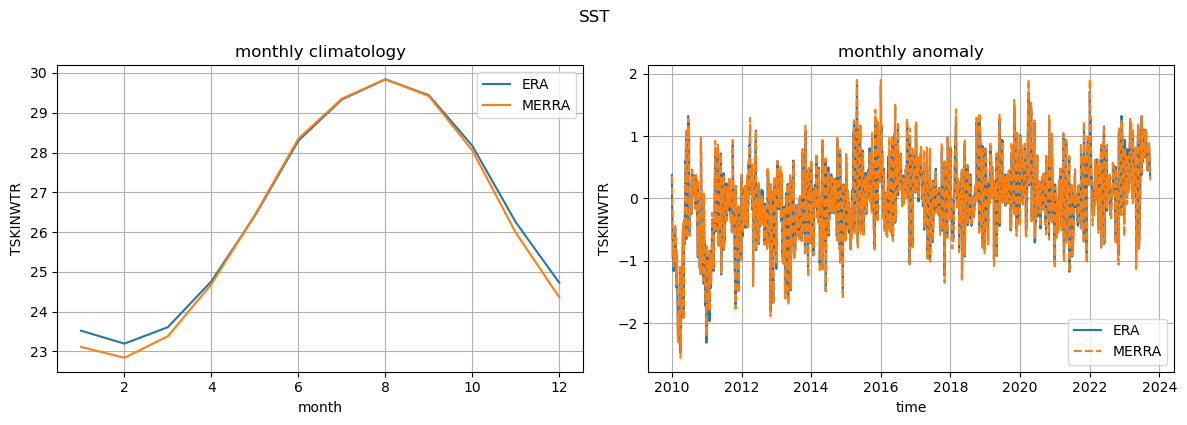

In [108]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

sst_clim_e.plot(ax=ax0, label='ERA')
sst_clim_m.plot(ax=ax0, label='MERRA')
ax0.set_title('monthly climatology')
ax0.grid()
ax0.legend()

sst_anom_e.mean(['latitude', 'longitude']).plot(label='ERA', ax=ax1)
sst_anom_m.mean(['lat', 'lon']).plot(ax=ax1, label='MERRA', linestyle='--')
ax1.set_title('monthly anomaly')
ax1.grid()
ax1.legend()

plt.tight_layout()
plt.suptitle('SST', y=1.05);

In [121]:
import numpy as np

for (i,j) in zip(np.arange(1,13), range(12)):
    print(i,': ', f'{sst_clim_e.values[j]}')

1 :  23.522586499995022
2 :  23.19682080888121
3 :  23.61121098166784
4 :  24.764911316069536
5 :  26.412377749666167
6 :  28.29665078370413
7 :  29.332607334408177
8 :  29.8392145998908
9 :  29.43976370434783
10 :  28.168283567305988
11 :  26.245446504279123
12 :  24.725600771711026


In [122]:
for (i,j) in zip(np.arange(1,13), range(12)):
    print(i,': ', f'{sst_clim_m.values[j]}')

1 :  23.114086151123047
2 :  22.840757369995117
3 :  23.384145736694336
4 :  24.691118240356445
5 :  26.43486785888672
6 :  28.34722137451172
7 :  29.3537654876709
8 :  29.84101676940918
9 :  29.41970443725586
10 :  28.050174713134766
11 :  25.981382369995117
12 :  24.361452102661133


In [86]:
mo_clim_e = era.groupby('time.month').mean(['time', 'latitude', 'longitude'])
mo_anom_e = era.groupby('time.month') - mo_clim_e

#mo_clim_m = (sw_merra).groupby('time.month').mean(['time', 'latitude', 'longitude'])
#mo_anom_m = (sw_merra).groupby('time.month') - mo_clim_m

mo_clim_m = merra.groupby('time.month').mean(['time', 'lat', 'lon'])
mo_anom_m = merra.groupby('time.month') - mo_clim_m

In [87]:
def plot_clims(da_e, da_m, fig_title):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

    mo_clim_e[f'{da_e}'].plot(ax=ax0, label='ERA')
    mo_clim_m[f'{da_m}'].plot(ax=ax0, label='MERRA')
    ax0.set_title('monthly climatology')
    ax0.grid()
    ax0.legend()
    
    mo_anom_e[f'{da_e}'].mean(['latitude', 'longitude']).plot(label='ERA', ax=ax1)
    mo_anom_m[f'{da_m}'].mean(['lat', 'lon']).plot(ax=ax1, label='MERRA', linestyle='--')
    ax1.set_title('monthly anomaly')
    ax1.grid()
    ax1.legend()
    
    plt.tight_layout()
    plt.suptitle(f'{fig_title}', y=1.05);

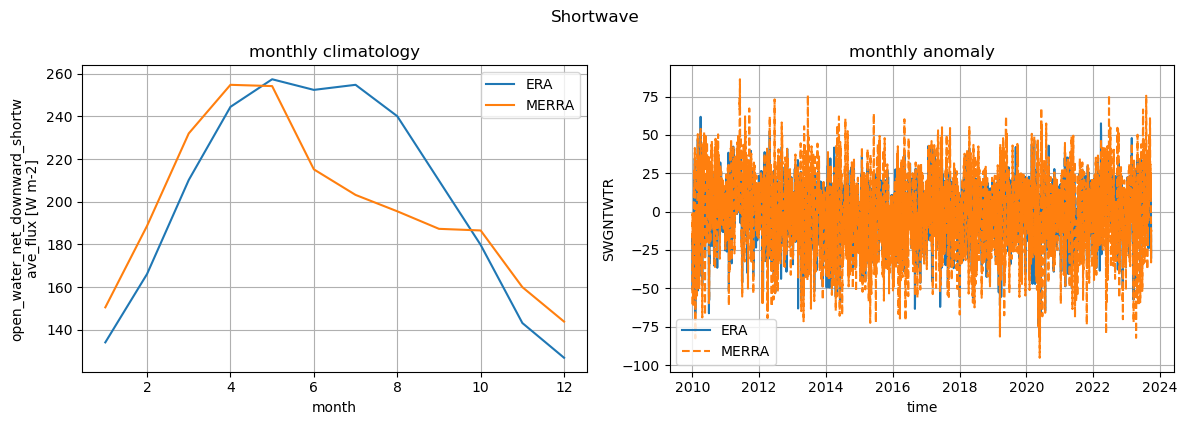

In [88]:
plot_clims('ssr', 'SWGNTWTR', 'Shortwave')

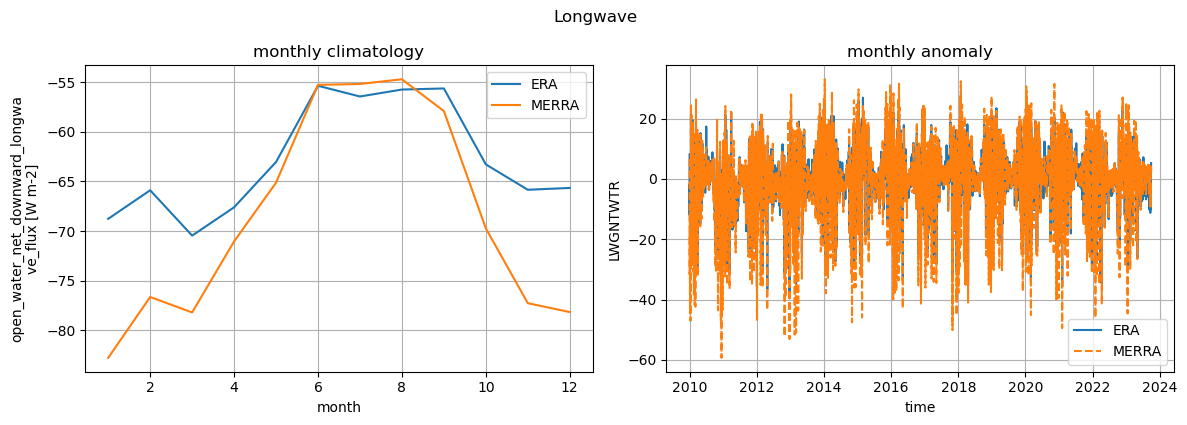

In [89]:
plot_clims('str', 'LWGNTWTR', 'Longwave')

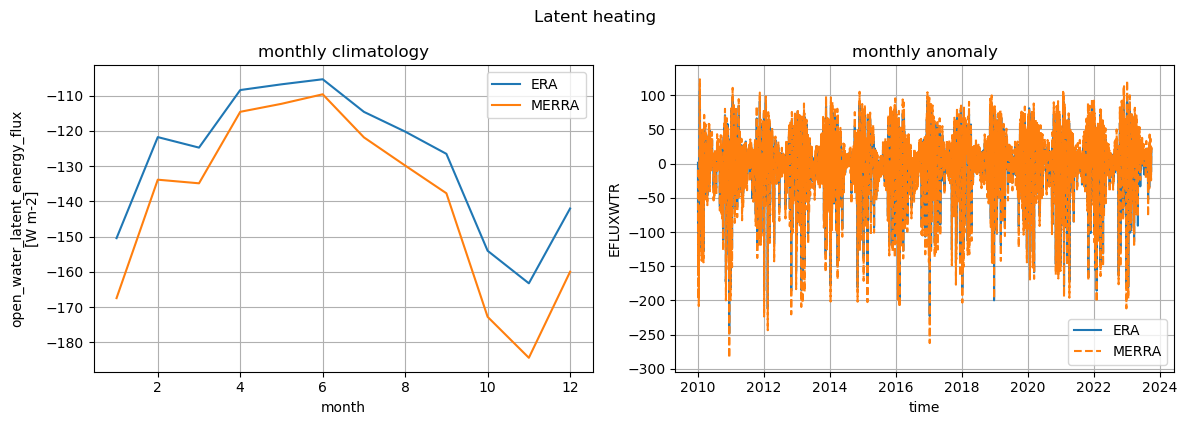

In [90]:
plot_clims('slhf', 'EFLUXWTR', 'Latent heating')

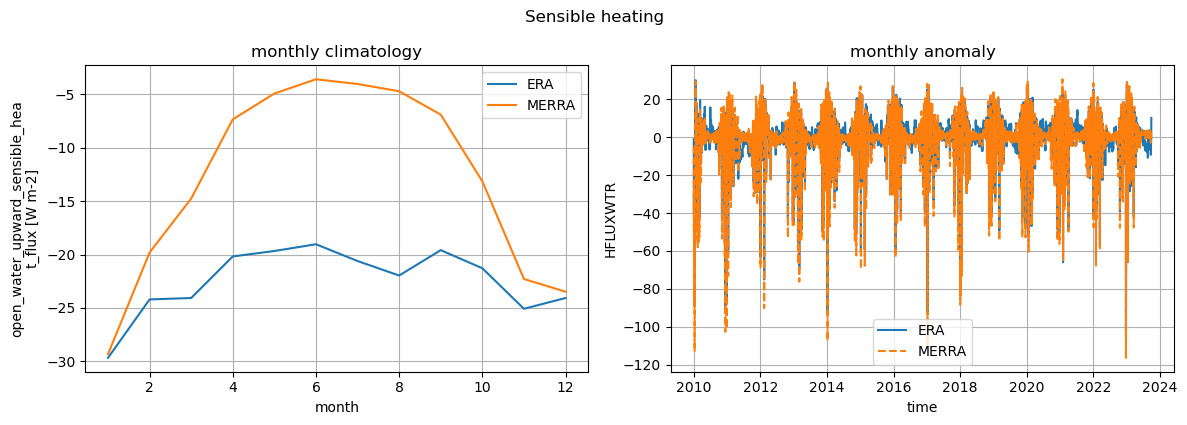

In [91]:
plot_clims('sshf', 'HFLUXWTR', 'Sensible heating')

## Detrended Shortwave

In [17]:
detrend_e = xr.apply_ufunc(detrend, era.fillna(0.), kwargs=dict(axis=-1),
                                   input_core_dims=[['time']],
                                   output_core_dims=[['time']],
                                   output_dtypes=[era.ssr.dtype],
                                   dask='parallelized').reset_coords(drop=True)

In [18]:
detrend_m = xr.apply_ufunc(detrend, merra.fillna(0.), kwargs=dict(axis=-1),
                                   input_core_dims=[['time']],
                                   output_core_dims=[['time']],
                                   output_dtypes=[merra.SWGNTWTR.dtype],
                                   dask='parallelized').reset_coords(drop=True)

In [19]:
detrend_e

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 41, longitude: 113, time: 5019)
Coordinates:
  * latitude   (latitude) float32 164B 21.0 21.25 21.5 21.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 40kB 2010-01-01 2010-01-02 ... 2023-09-28
Data variables:
    slhf       (latitude, longitude, time) float64 186MB 42.24 41.75 ... 135.0
    sshf       (latitude, longitude, time) float64 186MB 40.03 33.83 ... 7.147
    ssr        (latitude, longitude, time) float64 186MB -150.8 ... -191.6
    sst        (latitude, longitude, time) float64 186MB 0.0 0.0 ... -0.08276
    str        (latitude, longitude, time) float64 186MB 42.89 33.69 ... 28.44
    ssrd       (latitude, longitude, time) float64 186MB 0.0 0.0 ... 62.22 -46.2
    strd       (latitude, longitude, time) float64 186MB 0.0 0.0 ... 335.6 345.7

In [20]:
detrend_m

<xarray.Dataset> Size: 95MB
Dimensions:   (lat: 21, lon: 45, time: 5019)
Coordinates:
  * lat       (lat) float64 168B 21.0 21.5 22.0 22.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 40kB 2010-01-01 2010-01-02 ... 2023-09-28
Data variables:
    EFLUXWTR  (lat, lon, time) float32 19MB 0.0 0.0 0.0 ... 94.53 42.83 -13.85
    HFLUXWTR  (lat, lon, time) float32 19MB 0.0 0.0 0.0 ... 9.043 6.941 1.803
    LWGNTWTR  (lat, lon, time) float32 19MB 0.0 0.0 0.0 0.0 ... 12.0 21.31 20.73
    SWGNTWTR  (lat, lon, time) float32 19MB 0.0 0.0 0.0 ... 11.21 -43.58 -66.16
    TSKINWTR  (lat, lon, time) float32 19MB 0.0 0.0 0.0 0.0 ... 2.288 2.29 2.237

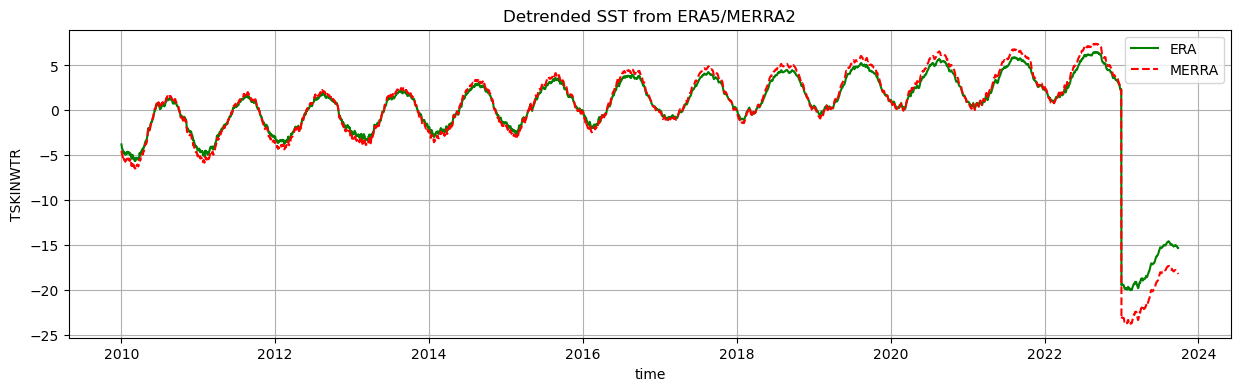

In [38]:
#multiply by hrs in a day to get back era sst values
(detrend_e.sst*60*60).mean(['latitude', 'longitude']).isel(time=slice(None, -1)).plot(figsize=(15,4), color='green', label='ERA')
(detrend_m.TSKINWTR).mean(['lat', 'lon']).plot(color='red', linestyle='--',label='MERRA')
plt.grid()
plt.legend()
plt.title('Detrended SST from ERA5/MERRA2');

In [23]:
mo_clim_de = detrend_e.groupby('time.month').mean(['time']).mean(['latitude', 'longitude'])
mo_anom_de = detrend_e.groupby('time.month') - mo_clim_de

mo_clim_dm = detrend_m.groupby('time.month').mean(['time']).mean(['lat', 'lon'])
mo_anom_dm = detrend_m.groupby('time.month') - mo_clim_dm

In [24]:
def plot_detrended_clims(da_e, da_m, fig_title):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

    mo_clim_de[f'{da_e}'].plot(ax=ax0, label='ERA')
    mo_clim_dm[f'{da_m}'].plot(ax=ax0, label='MERRA')
    ax0.set_title('monthly climatology detrended')
    ax0.grid()
    ax0.legend()
    
    mo_anom_de[f'{da_e}'].mean(['latitude', 'longitude']).plot(label='ERA', ax=ax1)
    mo_anom_dm[f'{da_m}'].mean(['lat', 'lon']).plot(ax=ax1, label='MERRA', linestyle='--')
    ax1.set_title('monthly anomaly detrended')
    ax1.grid()
    ax1.legend()
    
    plt.tight_layout()
    plt.suptitle(f'{fig_title} - detrended', y=1.05);

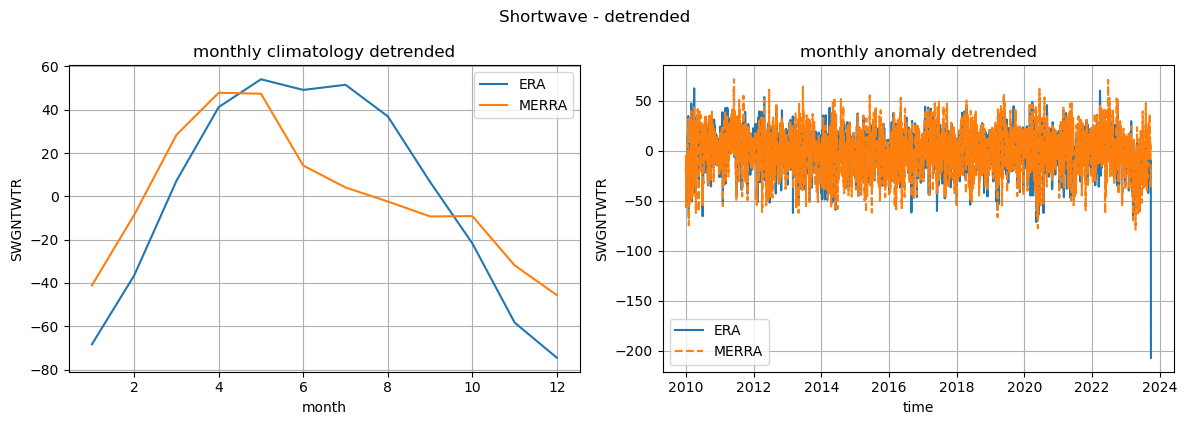

In [25]:
plot_detrended_clims('ssr', 'SWGNTWTR', 'Shortwave')

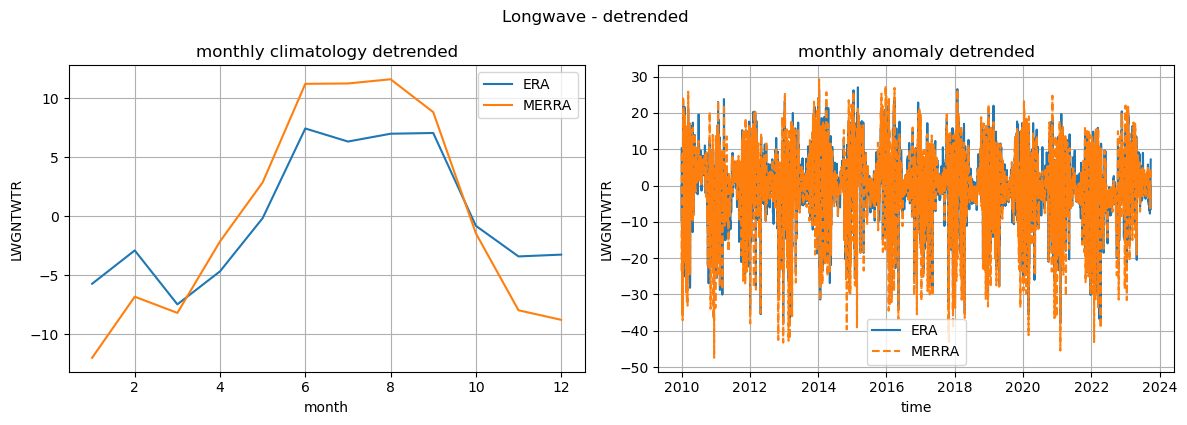

In [26]:
plot_detrended_clims('str', 'LWGNTWTR', 'Longwave')

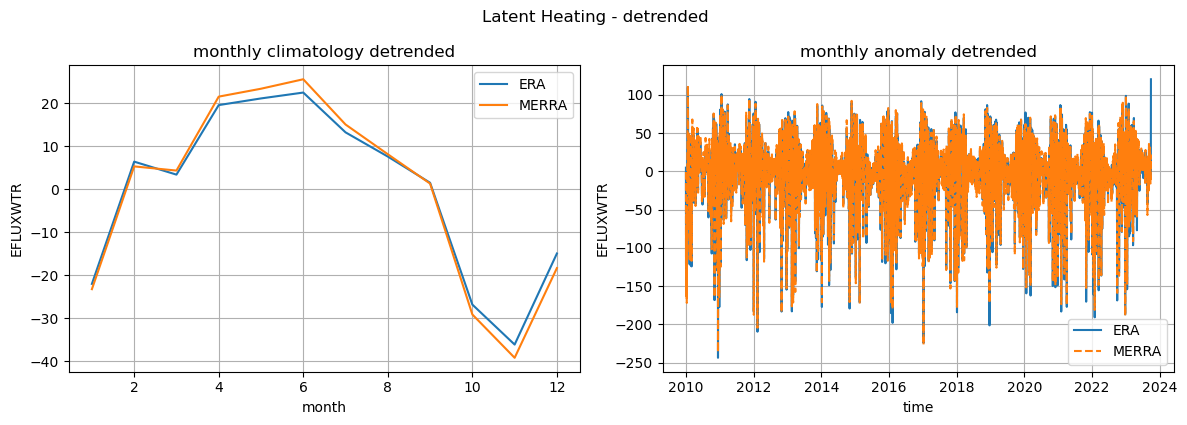

In [27]:
plot_detrended_clims('slhf', 'EFLUXWTR', 'Latent Heating')

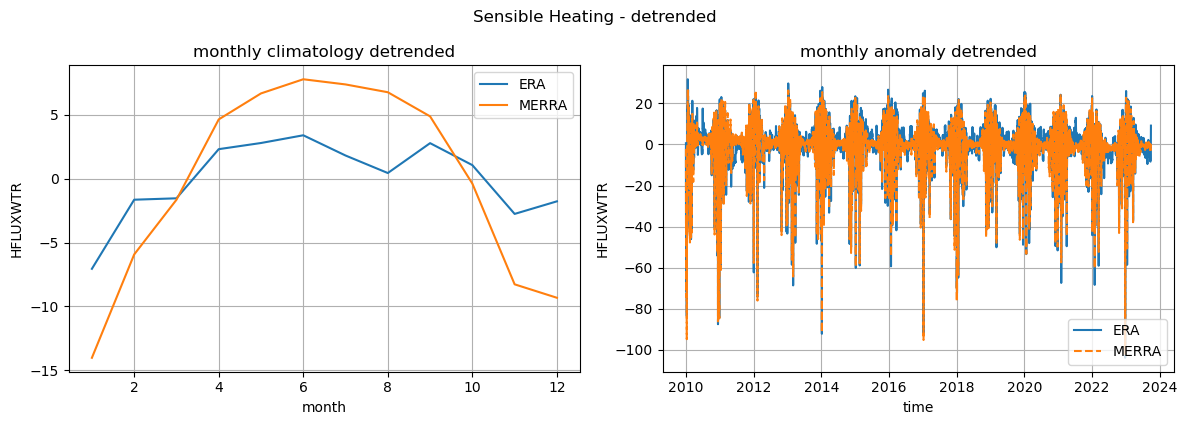

In [28]:
plot_detrended_clims('sshf', 'HFLUXWTR', 'Sensible Heating')